In [1]:
import kagglehub
dataset_path = kagglehub.dataset_download("awsaf49/brats20-dataset-training-validation")
print("Path to dataset files:", dataset_path)

Path to dataset files: /kaggle/input/brats20-dataset-training-validation


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
import os
import time
import gc

import nibabel as nib

from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as transforms

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

print("Random seed set.")

Random seed set.


In [3]:
class MRISegDataset(Dataset):
    def __init__(self, base_path, transform=None):
        """
        Args:
            base_path (str): Path to the dataset folder.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.base_path = base_path
        self.patients = [p for p in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, p))]
        self.transform = transform
        
    def __len__(self):
        return len(self.patients)*155

    def __getitem__(self, ind):
        """
        Args:
            idx (int): Index of the patient to fetch data for.

        Returns:
            dict: A dictionary containing 'image', 'segmentation', and optionally 'patient_id'.
        """
        patient_id = self.patients[ind//155]
        if patient_id == 'BraTS20_Training_355': 
            flair_path = os.path.join(self.base_path, patient_id, "W39_1998.09.19_Segm.nii")
            seg_path = os.path.join(self.base_path, patient_id, "W39_1998.09.19_Segm.nii")
        else:
            flair_path = os.path.join(self.base_path, patient_id, f"{patient_id}_flair.nii")
            seg_path = os.path.join(self.base_path, patient_id, f"{patient_id}_seg.nii")

        flair = nib.load(flair_path).get_fdata()[:, :, ind%155].reshape(1, 240, 240)
        seg = nib.load(seg_path).get_fdata()[:, :, ind%155].reshape(1, 240, 240)
        seg = np.where(seg==4, 3, seg)

        # Normalization
        flair = (flair - 0) / (900 - 0)

        flair = torch.tensor(flair, dtype=torch.float32)
        seg = torch.tensor(seg, dtype=torch.long)
        

        if self.transform:
            flair = self.transform(flair)
            seg = self.transform(seg)

        sample = {'image': flair, 'segmentation': seg, 'patient_id': patient_id}

        return sample

In [4]:
base_path = dataset_path +'/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'
brats_dataset = MRISegDataset(base_path=base_path, transform=transforms.Resize((256, 256)))

# Example: Access a single sample
sample = brats_dataset[0]
print("Image shape:", sample['image'].shape)
print("Segmentation shape:", sample['segmentation'].shape)
print("Patient ID:", sample['patient_id'])

Image shape: torch.Size([1, 256, 256])
Segmentation shape: torch.Size([1, 256, 256])
Patient ID: BraTS20_Training_083


In [5]:
def dice_coefficient(pred, target, smooth=1e-6):
    pred = pred.contiguous()
    target = target.contiguous()

    pred_class_all = torch.argmax(pred, dim=1)
    
    dice_total = []
    for class_ind in range(4):
        pred_class = (pred_class_all == class_ind).float()
        target_class = (target == class_ind).float()
        
        intersection = (pred_class * target_class).sum(dim=(1,2))
        union = pred_class.sum(dim=(1,2)) + target_class.sum(dim=(1,2))
        
        dice_class = (2. * intersection + smooth) / (union + smooth)
        dice_total.append(dice_class)
    
    return torch.mean(torch.stack(dice_total))

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Currently using: {device}')

Currently using: cuda


In [7]:
class UNet_Big(nn.Module):
    def __init__(self):
        super(UNet_Big, self).__init__()

        self.conv1_1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2)

        self.conv2_1 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2)

        self.conv3_1 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
    
        self.up4 = nn.ConvTranspose2d(16, 32, kernel_size=2, stride=2)
        self.conv4_1 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)

        self.up5 = nn.ConvTranspose2d(16, 16, kernel_size=2, stride=2)
        self.conv5_1 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(16, 4, kernel_size=3, padding=1)

    def forward(self, x):
        encoder1_1 = torch.relu(self.conv1_1(x))
        encoder1_2 = torch.relu(self.conv1_2(encoder1_1))
        encoder1_pool = self.pool1(encoder1_2)

        encoder2_1 = torch.relu(self.conv2_1(encoder1_pool))
        encoder2_2 = torch.relu(self.conv2_2(encoder2_1))
        encoder2_pool = self.pool2(encoder2_2)

        bottleneck_1 = torch.relu(self.conv3_1(encoder2_pool))
        bottleneck_2 = torch.relu(self.conv3_2(bottleneck_1))

        decode2_up = self.up4(bottleneck_2)
        decode2_concat = torch.cat([decode2_up, encoder2_2], dim=1)
        decode2_1 = torch.relu(self.conv4_1(decode2_concat))
        decode2_2 = torch.relu(self.conv4_2(decode2_1))

        decode1_up = self.up5(decode2_2)
        decode1_concat = torch.cat([decode1_up, encoder1_2], dim=1)
        decode1_2 = torch.relu(self.conv5_1(decode1_concat))
        decode1_3 = self.conv5_2(decode1_2)

        return decode1_3

# Instantiate the model
model = UNet_Big()

# Print model summary
print(model)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

UNet_Big(
  (conv1_1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2_1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3_1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (up4): ConvTranspose2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
  (conv4_1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (up5): ConvTranspose2d(16, 16, kernel_size=(2, 2), stride=(2, 2))
  (conv5_1): Conv2d(32, 16, kernel_size=(3, 3), str

In [8]:
batch_size = 16
data_loader = DataLoader(brats_dataset, batch_size=batch_size, shuffle=True, pin_memory=True,
                         num_workers=2)
print(f"Number of Batches: {len(data_loader)}")

model_big = UNet_Big()
if torch.cuda.is_available(): 
    model_big = model_big.cuda()
    print("Moved to cuda.")
criterion_big = nn.CrossEntropyLoss()
optimizer_big = torch.optim.Adam(model_big.parameters(), lr=1e-3)

Number of Batches: 3575
Moved to cuda.


In [9]:
num_epochs = 5
training_losses = []
epoch_times = []

for epoch in range(num_epochs):
    epoch_start_time = time.time()
    model.train()
    running_loss = 0.0

    for batch_idx, batch in enumerate(data_loader):
        batch_start_time = time.time()
        images = batch['image'].to(device) 
        segmentations = batch['segmentation'].squeeze(1).to(device)

        optimizer_big.zero_grad()
    
        outputs = model_big(images)
        loss = criterion_big(outputs, segmentations)
        
        loss.backward()
        optimizer_big.step()

        running_loss += loss.item()
        
        del images
        del segmentations
        torch.cuda.empty_cache()
        gc.collect()
        
        if batch_idx%300 == 0:
            print(f"Batch {batch_idx}/{len(data_loader)}, Time: {time.time()-batch_start_time:.4f}, Loss: {loss.item():.4f}")
        
    avg_loss = running_loss / len(data_loader)
    epoch_time = time.time()-epoch_start_time
    print(f"Epoch {epoch+1}/{num_epochs}, Time: {epoch_time:.4f}, Loss: {avg_loss:.4f}")

    print("Saving weights")
    torch.save(model.state_dict(), f"UNet2_weights_{epoch}.pth")
    training_losses.append(avg_loss)
    epoch_times.append(epoch_time)

with open("UNet2.txt", "w") as f:
    f.write("Training_losses: \n")
    for i in training_losses: f.write(str(i)+"\n")
    f.write("\nEpoch_times: \n")
    for i in epoch_times: f.write(str(i)+"\n")

Batch 0/3575, Time: 1.2567, Loss: 1.3964
Batch 300/3575, Time: 0.3253, Loss: 0.0646
Batch 600/3575, Time: 0.3117, Loss: 0.0515
Batch 900/3575, Time: 0.2464, Loss: 0.0810
Batch 1200/3575, Time: 0.3326, Loss: 0.0529
Batch 1500/3575, Time: 0.2326, Loss: 0.0479
Batch 1800/3575, Time: 0.3297, Loss: 0.0492
Batch 2100/3575, Time: 0.2325, Loss: 0.0432
Batch 2400/3575, Time: 0.2360, Loss: 0.0562
Batch 2700/3575, Time: 0.3203, Loss: 0.0219
Batch 3000/3575, Time: 0.2299, Loss: 0.0174
Batch 3300/3575, Time: 0.2715, Loss: 0.0463
Epoch 1/5, Time: 1667.1382, Loss: 0.0473
Saving weights
Batch 0/3575, Time: 0.5105, Loss: 0.0204
Batch 300/3575, Time: 0.2369, Loss: 0.0315
Batch 600/3575, Time: 0.3379, Loss: 0.0189
Batch 900/3575, Time: 0.2364, Loss: 0.0128
Batch 1200/3575, Time: 0.3389, Loss: 0.0469
Batch 1500/3575, Time: 0.2504, Loss: 0.0342
Batch 1800/3575, Time: 0.3395, Loss: 0.0319
Batch 2100/3575, Time: 0.2372, Loss: 0.0269
Batch 2400/3575, Time: 0.3290, Loss: 0.0327
Batch 2700/3575, Time: 0.3238, L

In [10]:
with open("UNet2.txt", "r") as f:
    content = f.read()

print(content)

Training_losses: 
0.04726752118852276
0.03146061282722162
0.02832907700113353
0.026679587014266974
0.0254085939694717

Epoch_times: 
1667.1381542682648
1628.9812817573547
1584.9219417572021
1581.272633075714
1578.2449669837952



[0.04726752118852276, 0.03146061282722162, 0.02832907700113353, 0.026679587014266974, 0.0254085939694717]


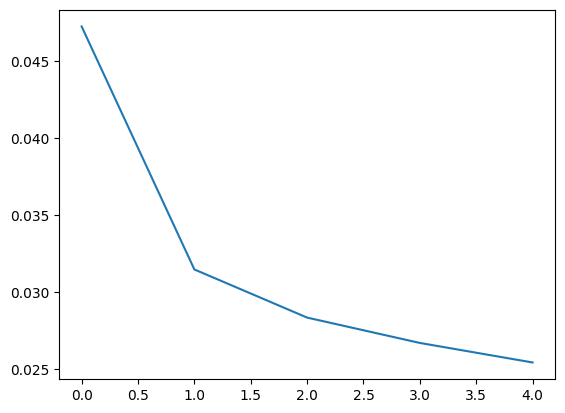

In [11]:
plt.plot(training_losses)
print(training_losses)

[1667.1381542682648, 1628.9812817573547, 1584.9219417572021, 1581.272633075714, 1578.2449669837952]


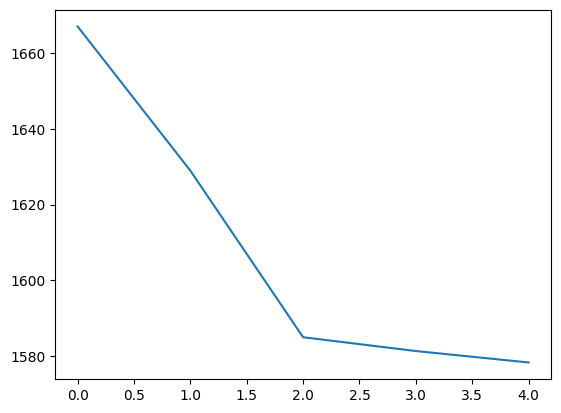

In [12]:
plt.plot(epoch_times)
print(epoch_times)